# Project 4: PMF with KNN and Kernel Ridge Post-processing

In this project, we explore probabilistic matrix factorization for recommender system. The goal is to match consumers with most appropriate products. We use two different methods for post-processing: KNN and Kernel Ridge Regression. We combine the prediction results from PMF and post-processing by using linear regression.

## Step 1: Load Data and Train-test Split
Import modules and packages.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pylab as plt
import PMF_model
%matplotlib inline

Load data and do train_test_split. Here we split again the train set into train set and validation set.

In [13]:
data = pd.read_csv('ratings.csv')

# train_test_split
train, test = train_test_split(data, test_size = 0.2, stratify = data['userId'])

# Comment out the line below not to include validation set
train, validation = train_test_split(train, test_size = 0.1, stratify = train['userId'])

train_data = np.array(train.iloc[:,:-1])
test_data = np.array(test.iloc[:,:-1])

# Comment out the line below not to include validation set
validation_data = np.array(validation.iloc[:,:-1])

num_users = max(data['userId'].values)
num_items = max(data['movieId'].values)

## Step 2: Matrix Factorization and Parameter Tuning
PMF from module PMF_model perform gradien descent to do probabilistic matrix factorization. The algorithm consider case that there are new users and movies adding to the dataset used to train. That is, the dimension of the matrix R (n*m), U (f*n), V (f*m) is dynamic.

Define function for grid search cross validation. The function takes in lists for sigma, sigma_u, sigma_v and latent_size each and return lists of sets of parameters and corresponding test_rmse.

In [14]:
# grid search for PMF
def GridSearch(sigma, sigma_u, sigma_v, latent_size):
    from sklearn.model_selection import KFold
    from statistics import mean
    params = []
    test_rmse = []

    # performing cv with k=3 for each set of parameters
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    for s in sigma:
        for su in sigma_u:
            for sv in sigma_v:
                for ls in latent_size:
                    print("Training with sigma={:f}, sigma_u={:f}, sigma_v={:f}, latent_size={:d}".format(s, su, sv, ls))
                    params.append([s, su, sv, ls])
                    model=PMF_model.PMF(m = num_items, n=num_users, sigma=s, sigma_u=su, sigma_v=sv, latent_size=ls)
                    rmse_list = []
                    
                    # KFold
                    cnt=1
                    for train_index, test_index in kf.split(train_data):
                        print(" Training fold {:d}".format(cnt))
                        train_k = train_data[train_index, :]
                        test_k = train_data[test_index, :]
                        U, V, validation_rmse = model.fit(train_data=train_k, validation_data=validation_data)
                        preds = model.predict(data=test_k)

                        # get rmse for the given fold
                        rmse = sqrt(mean_squared_error(test_k[:, 2],preds))
                        rmse_list.append(rmse)
                        cnt+=1

                    # Get average rmse for all folds for the given set of parameters
                    test_rmse.append(mean(rmse_list))
                    print(" rmse:{:f}\n".format(mean(rmse_list)))
    return params, test_rmse

From testing different values, we observed that the sigmas' are the parameters that affects RMSE the most. So we tuned them first. To aim for lambdas 0.01, 0.001, and 0.0001, we did grid search with sigma fixed and only changed sigma_u and sigma_v. We repeated this process with different sigmas.

In [15]:
sigma=[0.001]
sigma_u=[0.1, 0.03, 0.01]
sigma_v=[0.1, 0.03, 0.01]
latent_size=[10]

params, test_rmse = GridSearch(sigma, sigma_u, sigma_v, latent_size)
best_idx = test_rmse.index(min(test_rmse))
print("Best parameters: {}".format(params[best_idx]))
print("Best rmse:{}".format(min(test_rmse)))
best_rmse = min(test_rmse)
best_params = params[best_idx]

In [16]:
sigma=[0.01]
sigma_u=[1.0, 0.3, 0.1]
sigma_v=[1.0, 0.3, 0.1]
latent_size=[10]

params, test_rmse = GridSearch(sigma, sigma_u, sigma_v, latent_size)
best_idx = test_rmse.index(min(test_rmse))
print("Best parameters: {}".format(params[best_idx]))
print("Best rmse:{}".format(min(test_rmse)))
if min(test_rmse)<best_rmse:
    best_rmse = min(test_rmse)
    best_params = params[best_idx]

In [17]:
sigma=[1.0]
sigma_u=[10.0, 3.0, 1.0]
sigma_v=[10.0, 3.0, 1.0]
latent_size=[10]

params, test_rmse = GridSearch(sigma, sigma_u, sigma_v, latent_size)
best_idx = test_rmse.index(min(test_rmse))
print("Best parameters: {}".format(params[best_idx]))
print("Best rmse:{}".format(min(test_rmse)))
if min(test_rmse)<best_rmse:
    best_rmse = min(test_rmse)
    best_params = params[best_idx]

From the above grid search, we concluded that smaller sigmas work better. Then we performed cross validation for a different latent size for the smaller sigmas.

In [18]:
sigma=[best_params[0]]
sigma_u=[best_params[1]]
sigma_v=[best_params[2]]
latent_size=[20]

params, test_rmse = GridSearch(sigma, sigma_u, sigma_v, latent_size)
best_idx = test_rmse.index(min(test_rmse))
if min(test_rmse)<best_rmse:
    best_rmse = min(test_rmse)
    best_params = params[best_idx]
print("Best parameters: {}".format(best_params))
print("Best rmse:{}".format(best_rmse))

Finally, train the model with the whole training data, using the best parameters(sigma=0.001, sigma_u=0.03, sigma_v=0.03, latent_size=10) found from grid search.

In [19]:
# construct model
sigma = [best_params[0]]
sigma_u = [best_params[1]]
sigma_v = [best_params[2]]
latent_size = [best_params[3]]

num_iter = 2000
model = PMF_model.PMF(m = num_items, n = num_users, sigma = sigma, sigma_u = sigma_u, sigma_v = sigma_v, lr=0.001, latent_size=latent_size)
print('PMF(sigma={:f}, sigma_u={:f}, sigma_v={:f}, latent_size={:d})'.format(sigma, sigma_u, sigma_v, latent_size))
print('\ntraining model...')
U, V, validation_rmse = model.fit(train_data=train_data, validation_data=validation_data)

train_preds = model.predict(data=train_data)
train['pmf_preds'] = train_preds
train_rmse = sqrt(mean_squared_error(train_data[:, 2],train_preds))
print('train rmse:{:f}'.format(train_rmse))

print('\ntesting model...')
preds = model.predict(data=test_data)
test['pmf_preds']=preds
test_rmse = sqrt(mean_squared_error(test_data[:, 2],preds))
print('test rmse:{:f}'.format(test_rmse))

# np.save('U.npy', U)
# np.save('V.npy', V)

PMF(sigma=0.001000, sigma_u=0.030000, sigma_v=0.030000, latent_size=10)

training model...
training iteration: 0, loss: 484617.041984, validation_rmse: 3.659554)
training iteration: 100, loss: 21772.462191, validation_rmse: 1.162506
convergence at iterations: 139
train rmse:0.699220

testing model...
test rmse:1.153616


In [20]:
# U=np.load('U.npy')
# V=np.load('V.npy')

Training and testing RMSE by different dimensions of factors and epochs are visualized below.

In [21]:
# Get RMSE
num_iter = 120
model_10 = PMF_model.PMF(m = num_items, n = num_users, sigma = sigma, sigma_u = sigma_u, sigma_v = sigma_v, lr=0.001, latent_size=10)
_, _, train_rmse_10, test_rmse_10 = model_10.fit(train_data=train_data, test_data = test_data)

model_20 = PMF_model.PMF(m = num_items, n = num_users, sigma = sigma, sigma_u = sigma_u, sigma_v = sigma_v, lr=0.001, latent_size=20)
_, _, train_rmse_20, test_rmse_20 = model_20.fit(train_data=train_data, test_data = test_data)

# np.save('train_rmse_10.npy', np.array(train_rmse_10))
# np.save('test_rmse_10.npy', np.array(test_rmse_10))
# np.save('train_rmse_20.npy', np.array(train_rmse_20))
# np.save('test_rmse_20.npy', np.array(test_rmse_20))

In [22]:
# train_rmse_10 = np.load('train_rmse_10.npy')
# test_rmse_10 = np.load('test_rmse_10.npy')
# train_rmse_20 = np.load('train_rmse_20.npy')
# test_rmse_20 = np.load('test_rmse_20.npy')

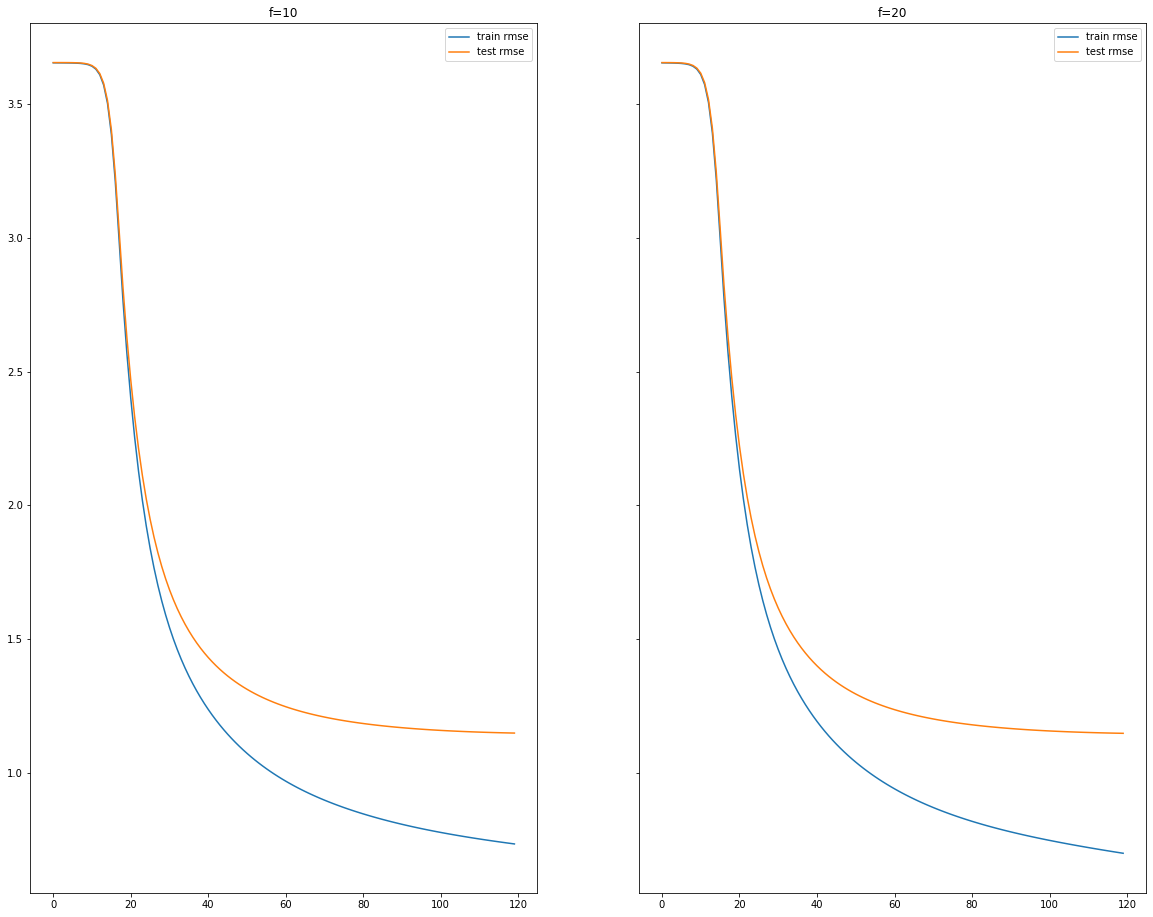

In [23]:
# Visualize RMSE
fig, ax = plt.subplots(1,2,figsize=(20,16), sharey=True)
sns.lineplot(x=range(120), y=train_rmse_10, ax=ax[0], label='train rmse')
sns.lineplot(x=range(120), y=test_rmse_10, ax=ax[0], label='test rmse')
ax[0].set_title('f=10')
ax[0].legend()

sns.lineplot(x=range(120), y=train_rmse_20, ax=ax[1], label='train rmse')
sns.lineplot(x=range(120), y=test_rmse_20, ax=ax[1], label='test rmse')
ax[1].set_title('f=20')
ax[1].legend();

## Step 3: Post-processing
Postporcessing is performed to improve accuracy.
### 1) KNN with K=1
We define similarity between movies i1 and i2 as the cosine similarity between vectors V_i1 and V_i2. Then we use the average rating of most similar movie as prediction. If there is no ratings for the closest movie, we set the prediction to 0.

In [24]:
# Post processing using K Nearest Neighbors with K=1
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=1, n_jobs=-1)
model_knn.fit(V.T)
dist, ind = model_knn.kneighbors(V.T,2)
nearest_movie = ind[:,1]+1

In [25]:
# Average rating of the nearest neighbor (0 if no ratings)
movie_rates = data.groupby(['movieId'])['rating'].mean()
test_nn = nearest_movie[test['movieId']-1]
train_nn = nearest_movie[train['movieId']-1]
test['knn_preds'] = list(movie_rates[test_nn].fillna(0))
train['knn_preds'] = list(movie_rates[train_nn].fillna(0))

In [26]:
# test and train RMSE of KNN prediction
print(sqrt(np.array(mean_squared_error(test['rating'],test['knn_preds']))))
print(sqrt(np.array(mean_squared_error(train['rating'],train['knn_preds']))))

1.5262818256469137
1.3493580175869981


### 2) Kernel Ridge Regression
Define y as user specific ratings. X consists of normalized vector of factors for movies rated by the user in each row. Using y and X, we solve Kernel Ridge Regression.

In [27]:
# Post processing using Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import normalize
# For user specific ratings
most_rated = data.groupby(['movieId']).count().sort_values(by = 'rating', ascending=False)
for userId in range(1,num_users+1):
    # get user specific data
    user_spec = train.loc[train['userId'] == userId]
    user_spec_test = test.loc[test['userId'] == userId]
    
    if (len(user_spec)!=0) and (len(user_spec_test)!=0):
        # use 500 most rated movies if the user rated more than 500 movies
        if(len(user_spec)>500):
            user_spec['num_rates']=list(most_rated.loc[user_spec['movieId'],'rating'])
            user_spec=user_spec.sort_values(by='num_rates', ascending=False)[:500]

        # get X and y for Kernel Ridge Regression
        X_train = normalize(V.T[user_spec['movieId']-1,:], axis=0)
        y_train = user_spec['rating']
        X_test = normalize(V.T[user_spec_test['movieId']-1,:], axis=0)

        # Construct and train model
        model_kr =  KernelRidge(kernel='rbf', alpha=0.5)
        cls = model_kr.fit(X_train,y_train)
        y_preds = cls.predict(X_test)
        train_preds = cls.predict(X_train)

        # get predictions
        test.loc[list(user_spec_test.index),'krr_preds'] = y_preds
        train.loc[list(user_spec.index),'krr_preds'] = train_preds
        if len((user_spec>500)): train['krr_preds'].fillna(0, inplace=True)

In [30]:
# test and train RMSE of Kerner Ridge Regression prediction
print(sqrt(np.array(mean_squared_error(test['rating'],test['krr_preds']))))
print(sqrt(np.array(mean_squared_error(train['rating'],train['krr_preds']))))

0.9329271334055824
1.385064219328171


## Step 4: Evaluation
Using linear regression, we combine the predictions from PMF and each post-processed predictions. Then we use RMSE to evaluate the combined models.
### 1) KNN with K=1

In [31]:
# Linear regression to combine PMF and KNN
from sklearn.linear_model import LinearRegression
lm_knn = LinearRegression(fit_intercept=False)
lm_knn.fit(X = np.vstack([train['knn_preds'], train['pmf_preds']]).T, y = train['rating'])
knn_beta1, knn_beta2 = lm_knn.coef_

In [32]:
# test rmse of KNN processed results
test['knn_processed_preds'] = knn_beta1*test['knn_preds'] + knn_beta2*test['pmf_preds']
sqrt(mean_squared_error(test['rating'], test['knn_processed_preds']))

1.1541276068819433


In [33]:
# train rmse of KNN processed results
train['knn_processed_preds'] = knn_beta1*train['knn_preds'] + knn_beta2*train['pmf_preds']
sqrt(mean_squared_error(train['rating'], train['knn_processed_preds']))

0.6987678769303419


### 2) Kernel Ridge Regression

In [34]:
# Linear regression to combine PMF and KRR
from sklearn.linear_model import LinearRegression
lm_krr = LinearRegression(fit_intercept=False)
lm_krr.fit(X = np.vstack([train['krr_preds'], train['pmf_preds']]).T, y = train['rating'])
krr_beta1, krr_beta2 = lm_krr.coef_

In [35]:
# test rmse of KRR processed results
test['krr_processed_preds'] = krr_beta1*test['krr_preds'] + krr_beta2*test['pmf_preds']
sqrt(mean_squared_error(test['rating'], test['krr_processed_preds']))

1.1426347248810556


In [36]:
# train rmse of KRR processed results
train['krr_processed_preds'] = krr_beta1*train['krr_preds'] + krr_beta2*train['pmf_preds']
sqrt(mean_squared_error(train['rating'], train['krr_processed_preds']))

0.6984023019886008


In [37]:
# train.to_csv('train.csv')
# test.to_csv('test.csv')

In [38]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

From the results above, we can observe that KRR post-processed results are better off by 0.01 RMSE compared to PMF predictions. On the other hand, KNN post-processed results are similar to PMF (worse off by 0.0005 RMSE). A possible explanation is that we use K=1 so the KNN predictions only depend on a single nearest item. This may have caused noised due to overfitting and have evened out the ensemble effect. Also, we are not given ratings for every movie in the first place, and more movies have been omitted as we set the KNN prediction to 0 for movies without ratings. Accordingly, almost half of the test prediction with KNN was set to 0. KNN may perform better with more data available.

### 3) Visualization in Boxplot

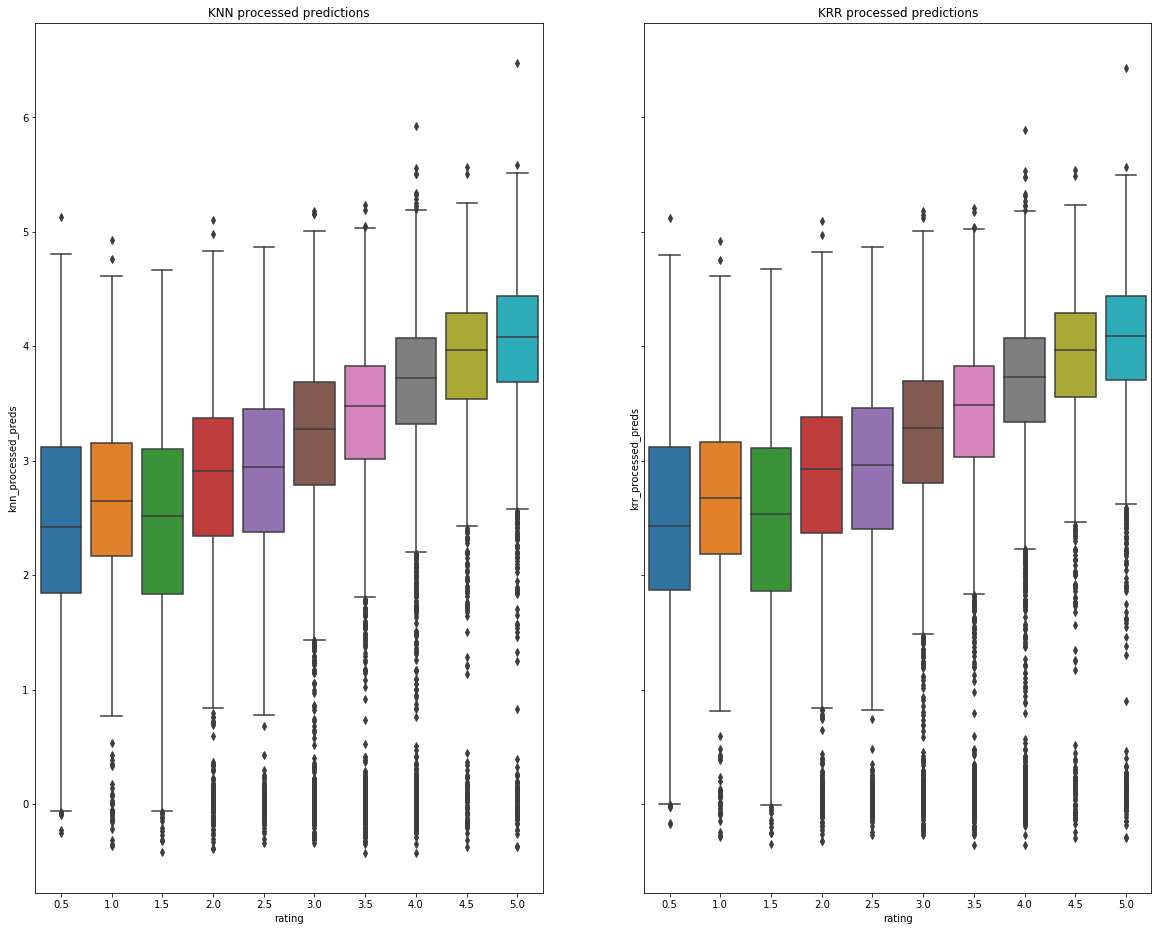

In [40]:
fig, ax = plt.subplots(1,2,figsize=(20,16), sharey=True)
sns.boxplot(x='rating', y='knn_processed_preds', data=test, ax = ax[0])
sns.boxplot(x='rating', y='krr_processed_preds', data=test, ax = ax[1])
ax[0].set_title('KNN processed predictions')
ax[1].set_title('KRR processed predictions');